### 딥러닝 기말 프로젝트
 - metric - IOU 사용
 - dataset :
https://www.kaggle.com/datasets/andrewmvd/hippocampus-segmentation-in-mri-images

# Data loading

x_train : train img files
// y_train : train masks files

x_val : validation img files // y_val : validation img files

In [ ]:
!mv kaggle.json /root/.kaggle/

In [1]:
!kaggle datasets download -d andrewmvd/hippocampus-segmentation-in-mri-images

 99% 797M/806M [00:03<00:00, 283MB/s]
100% 806M/806M [00:03<00:00, 255MB/s]


In [ ]:
!unzip /content/hippocampus-segmentation-in-mri-images.zip

In [3]:
import os
import nibabel as nib
import numpy as np
import math
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
#store path in the list
input_dir = 'Train'
target_dir = 'Train/Labels'

img_path = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith('.img')]
)

target_path = sorted(
    [os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith('.img') and not fname.startswith('.')]
)

print(img_path, target_path)

['Train/HFH_001.img', 'Train/HFH_002.img', 'Train/HFH_003.img', 'Train/HFH_004.img', 'Train/HFH_005.img', 'Train/HFH_006.img', 'Train/HFH_007.img', 'Train/HFH_008.img', 'Train/HFH_009.img', 'Train/HFH_010.img', 'Train/HFH_011.img', 'Train/HFH_012.img', 'Train/HFH_013.img', 'Train/HFH_014.img', 'Train/HFH_015.img', 'Train/HFH_016.img', 'Train/HFH_017.img', 'Train/HFH_018.img', 'Train/HFH_019.img', 'Train/HFH_020.img', 'Train/HFH_021.img', 'Train/HFH_022.img', 'Train/HFH_023.img', 'Train/HFH_024.img', 'Train/HFH_025.img'] ['Train/Labels/HFH_001_Hipp_Labels.img', 'Train/Labels/HFH_002_Hipp_Labels.img', 'Train/Labels/HFH_003_Hipp_Labels.img', 'Train/Labels/HFH_004_Hipp_Labels.img', 'Train/Labels/HFH_005_Hipp_Labels.img', 'Train/Labels/HFH_006_Hipp_Labels.img', 'Train/Labels/HFH_007_Hipp_Labels.img', 'Train/Labels/HFH_008_Hipp_Labels.img', 'Train/Labels/HFH_009_Hipp_Labels.img', 'Train/Labels/HFH_010_Hipp_Labels.img', 'Train/Labels/HFH_011_Hipp_Labels.img', 'Train/Labels/HFH_012_Hipp_Labels

# Prepare dataset

In [5]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    #print(scan.shape)
    return scan

def normalize(volume):
    """Normalize the volume"""
    mean = volume.mean()

    std = volume.std()

    volume = (volume - mean) / std

    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 256
    desired_height = 256
    if len(img.shape) != 4:
      img = np.expand_dims(img, 3)
    img = resize(img, (desired_width, desired_depth, desired_height))
    return img

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    volume = volume.transpose(2,0,1,3)
    return volume

def process_scan_Y(path):
    """Read and resize volume"""
    # Read scan
    #seg_labels = np.zeros((256, 256, 64, 2))
    volume = read_nifti_file(path)
    # Normalize
    #volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    volume = volume.transpose(2,0,1,3)
    volume[volume>0] = 1
    #seg_labels[:,:,:,1:] = volume
    return volume

In [ ]:
for i in range(len(target_path)-1):
  sample = process_scan_Y(target_path[i])
  print(sample.shape)

In [7]:
for i in range(len(img_path)-1):
  sample = process_scan(img_path[i])
  print(sample.shape)
  break

(256, 256, 64, 1)


In [8]:
x_scans = np.array([process_scan(path) for path in img_path])
y_scans = np.array([process_scan_Y(path) for path in target_path])

### Split the dataset

In [9]:
#split train and validation dataset
x_train = x_scans[:20]
y_train = y_scans[:20]
x_val = x_scans[20:]
y_val = y_scans[20:]

In [10]:
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 20 and 5.


In [11]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [12]:
batch_size = 1

train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

### Visualize the data

Dimension of the MRI is: (256, 256, 64, 1)


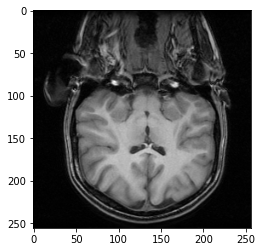

In [13]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]

print("Dimension of the MRI is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

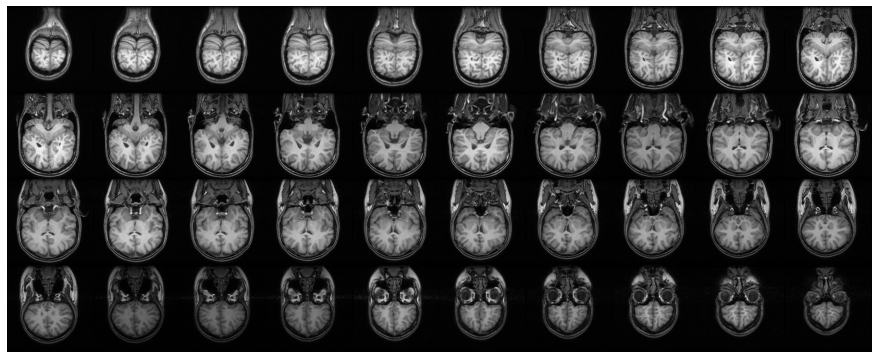

In [14]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 256, 256, image[:, :, 12:52])

# Train Model 

In [15]:
def get_model(width=256, height=256, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=32, kernel_size=3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=64, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=128, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Activation("relu")(x)
    x = layers.Conv3DTranspose(filters=128, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling3D(2)(x)

    x = layers.Activation("relu")(x)
    x = layers.Conv3DTranspose(filters=64, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling3D(2)(x)

    x = layers.Activation("relu")(x)
    x = layers.Conv3DTranspose(filters=32, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling3D(2)(x)

    outputs = layers.Conv3D(filters=1, kernel_size=3, padding='same', activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=256, height=256, depth=64)

In [16]:
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 256, 256, 64, 32)  896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 64, 32)  128      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 64, 32)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 128, 128, 32, 32)  0        
 )                                                               
                                                             

In [23]:
iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

def iou_metric(imgs_true, imgs_pred):
    print(imgs_true)
    print('-------')
    print(imgs_pred)
    num_images = len(imgs_true)
    scores = np.zeros(num_images)
    
    for i in range(num_images):
        if imgs_true[i].sum() == imgs_pred[i].sum() == 0:
            scores[i] = 1
        else:
            scores[i] = (iou_thresholds <= iou(imgs_true[i], imgs_pred[i])).mean()
            
    return scores.mean()

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [18]:
from keras import backend as K

### Compile method

- loss: dice_loss
- optimizer: Adam
- metrics: iou
- epoch: 100

In [69]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

dice_loss      = bce_dice_loss
metric_iou   = [iou_metric]

model.compile(
    loss=dice_loss,
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['acc']
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
#early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],
)

Epoch 1/100
20/20 - 24s - loss: -8.7901e-01 - acc: 0.9997 - val_loss: -4.8928e-01 - val_acc: 0.9986 - 24s/epoch - 1s/step
Epoch 2/100
20/20 - 20s - loss: -8.7481e-01 - acc: 0.9997 - val_loss: -5.3914e-01 - val_acc: 0.9988 - 20s/epoch - 984ms/step
Epoch 3/100
20/20 - 20s - loss: -8.8247e-01 - acc: 0.9997 - val_loss: -4.6372e-01 - val_acc: 0.9987 - 20s/epoch - 976ms/step
Epoch 4/100
20/20 - 19s - loss: -9.0234e-01 - acc: 0.9997 - val_loss: -3.0798e-01 - val_acc: 0.9985 - 19s/epoch - 953ms/step
Epoch 5/100
20/20 - 19s - loss: -9.0642e-01 - acc: 0.9998 - val_loss: -2.7913e-01 - val_acc: 0.9984 - 19s/epoch - 953ms/step
Epoch 6/100
20/20 - 19s - loss: -9.0766e-01 - acc: 0.9998 - val_loss: -3.3504e-01 - val_acc: 0.9985 - 19s/epoch - 964ms/step
Epoch 7/100
20/20 - 19s - loss: -9.0447e-01 - acc: 0.9997 - val_loss: -2.8717e-01 - val_acc: 0.9985 - 19s/epoch - 968ms/step
Epoch 8/100
20/20 - 19s - loss: -9.0907e-01 - acc: 0.9998 - val_loss: -3.5982e-01 - val_acc: 0.9986 - 19s/epoch - 960ms/step
Epo

# Plot the Train Graph

- plotting the accuracy and loss

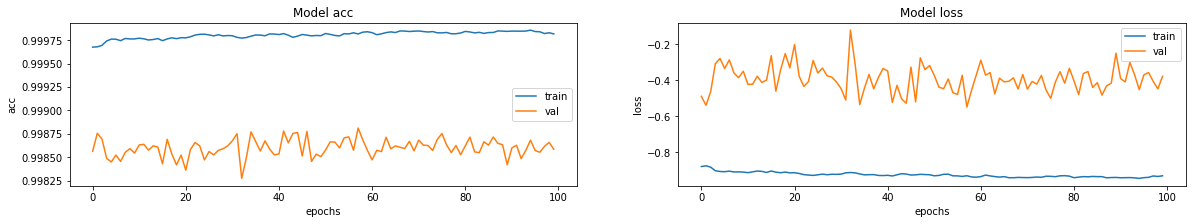

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Dimension of the MRI is: (256, 256, 64, 1)


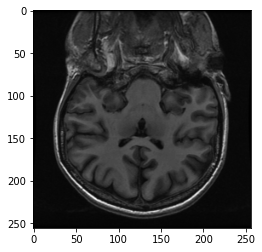

In [65]:
data = validation_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]

print("Dimension of the MRI is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

# Model IoU

In [72]:
import cv2
idx = 3
y_pred = model.predict(x_val)
y_pred = np.where(y_pred >= .4, y_pred, 0)
y_pred = np.where(y_pred < .4, y_pred, 1)


#y_pred = np.array([cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in y_pred])
#y_pred = np.expand_dims(y_pred, axis=-1)

1/1 [==============================] - 2s 2s/step


In [79]:
import tensorflow
m = tensorflow.metrics.MeanIoU(num_classes=2)
m.update_state(y_val[3], y_pred[3])
print(m.result().numpy())

0.69203424


# Prediction Visualization

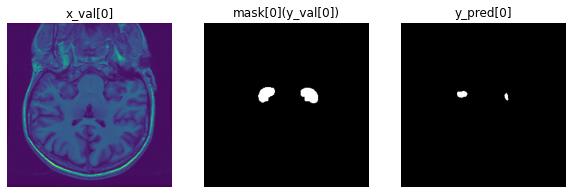

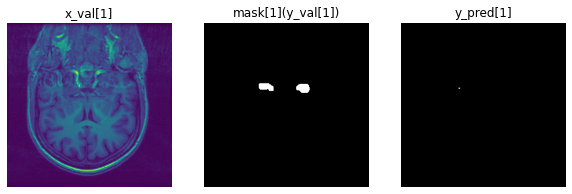

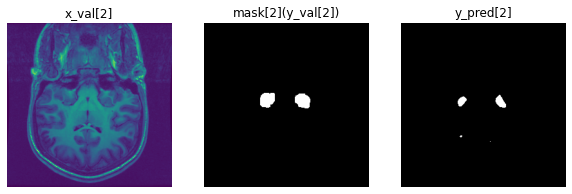

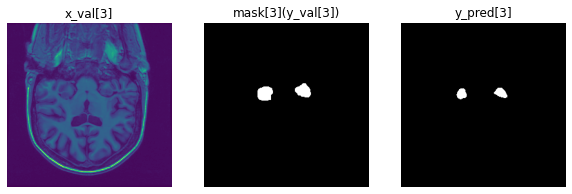

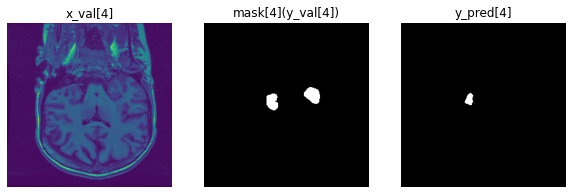

In [85]:
for idx in range(0, 5):
    plt.figure(figsize=(10,10))
    plt.subplot(1, 3, 1)
    plt.title('x_val[{}]'.format(idx))
    plt.imshow(x_val[idx][:,:,30,0])
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('mask[{}](y_val[{}])'.format(idx, idx))
    plt.imshow(y_val[idx][:,:,30,0],cmap='gray')

    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('y_pred[{}]'.format(idx))
    plt.imshow(y_pred[idx][:,:,30,0],cmap='gray')

    plt.axis('off')
    plt.show()

(-0.5, 255.5, 255.5, -0.5)

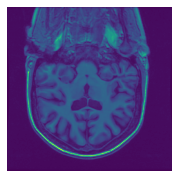

In [88]:
plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow(x_val[3][:,:,30,0])
plt.axis('off')

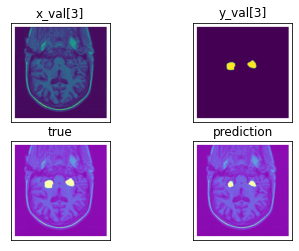

In [90]:
# 이미지 단순 합성 (blending_simple.py)

import cv2
import numpy as np
import matplotlib.pylab as plt

# ---① 연산에 사용할 이미지 읽기
img1 = cv2.imread('/content/x_val[3].png')
img2 = cv2.imread('/content/y_val[3].png')
img3 = cv2.imread('/content/y_pred[3].png')

# ---② 이미지 덧셈
img4 = cv2.add(img1, img2)  # 더하기 연산
img5 = cv2.add(img1, img3) # OpenCV 함수

imgs = {'x_val[3]':img1, 'y_val[3]':img2, 'true': img4, 'prediction': img5}

# ---③ 이미지 출력
for i, (k, v) in enumerate(imgs.items()):
    plt.subplot(2,2, i + 1)
    plt.imshow(v[:,:,::-1])
    plt.title(k)
    plt.xticks([]); plt.yticks([])

plt.show()

[scr.] https://keras.io/examples/vision/3D_image_classification/